# KRW IRS Bootstrapping using QuantLib

- **Scenario 1**: Piecewise Constant Instantaneous Forward (주어진 만기만 사용)
- **Scenario 2**: Linear Interpolation of IRS rates for intermediate maturities
- Step Function Chart로 Forward Rate 비교


## 1. 라이브러리 임포트


In [1]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Tuple, Optional
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# 타임스탬프 생성 함수
def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")


## 2. 입력 데이터 설정


In [2]:
# 기준일
today = ql.Date(17, 12, 2024)
ql.Settings.instance().evaluationDate = today

# KRW 캘린더 및 컨벤션
calendar = ql.SouthKorea()
day_count = ql.Actual365Fixed()
business_convention = ql.ModifiedFollowing
settlement_days = 2

# IRS 금리 데이터 (만기별) - 여기서 수정
irs_rates = {
    1: 0.02,
    2: 0.04,
    3: 0.05
}

# 최대 만기 (자동 계산)
max_maturity = max(irs_rates.keys())

print(f"기준일: {today}")
print(f"\n입력 IRS 금리:")
for years, rate in sorted(irs_rates.items()):
    print(f"  {years}년: {rate*100:.2f}%")


기준일: December 17th, 2024

입력 IRS 금리:
  1년: 2.00%
  2년: 4.00%
  3년: 5.00%


## 3. 유틸리티 함수


In [3]:
def linear_interpolate(x, x1, y1, x2, y2):
    """선형 보간"""
    return y1 + (y2 - y1) * (x - x1) / (x2 - x1)


def get_interpolated_rate(tenor: float) -> float:
    """주어진 tenor에 대한 보간된 금리 반환"""
    sorted_maturities = sorted(irs_rates.keys())
    
    # 첫 번째 만기 이하면 첫 번째 금리 사용
    if tenor <= sorted_maturities[0]:
        return irs_rates[sorted_maturities[0]]
    
    # 마지막 만기 이상이면 마지막 금리 사용
    if tenor >= sorted_maturities[-1]:
        return irs_rates[sorted_maturities[-1]]
    
    # 중간 만기: 선형 보간
    for i in range(len(sorted_maturities) - 1):
        if sorted_maturities[i] <= tenor <= sorted_maturities[i + 1]:
            return linear_interpolate(
                tenor,
                sorted_maturities[i], irs_rates[sorted_maturities[i]],
                sorted_maturities[i + 1], irs_rates[sorted_maturities[i + 1]]
            )
    
    return irs_rates[sorted_maturities[-1]]


## 4. QuantLib 부트스트래핑 함수


In [4]:
def create_irs_helpers(use_interpolation=False):
    """
    IRS Helper 생성
    use_interpolation: True면 중간 만기에 선형 보간된 금리 사용
    """
    helpers = []
    
    if use_interpolation:
        # Scenario 2: 선형 보간 사용 - 0.25년 간격으로 모든 만기 생성
        num_quarters = int(max_maturity * 4)
        
        for i in range(1, num_quarters + 1):
            tenor = i * 0.25
            rate = get_interpolated_rate(tenor)
            
            months = int(tenor * 12)
            swap_rate = ql.QuoteHandle(ql.SimpleQuote(rate))
            
            helper = ql.SwapRateHelper(
                swap_rate,
                ql.Period(months, ql.Months),
                calendar,
                ql.Quarterly,
                business_convention,
                day_count,
                ql.Euribor3M()
            )
            helpers.append(helper)
    else:
        # Scenario 1: 주어진 만기만 사용
        for years, rate in sorted(irs_rates.items()):
            swap_rate = ql.QuoteHandle(ql.SimpleQuote(rate))
            
            helper = ql.SwapRateHelper(
                swap_rate,
                ql.Period(years, ql.Years),
                calendar,
                ql.Quarterly,
                business_convention,
                day_count,
                ql.Euribor3M()
            )
            helpers.append(helper)
    
    return helpers


def build_curve(helpers):
    """Piecewise Flat Forward로 커브 생성"""
    curve = ql.PiecewiseFlatForward(settlement_days, calendar, helpers, day_count)
    curve.enableExtrapolation()
    return curve


def calculate_quarterly_zero_rates(curve, maturities):
    """Quarterly Compounding Zero Rate 계산"""
    spot_date = curve.referenceDate()
    results = []
    
    for tenor in maturities:
        target_date = spot_date + ql.Period(int(tenor * 12), ql.Months)
        
        zero_rate = curve.zeroRate(
            target_date,
            day_count,
            ql.Compounded,
            ql.Quarterly
        ).rate()
        
        results.append({
            'Tenor (Years)': tenor,
            'Zero Rate (%)': zero_rate * 100
        })
    
    return results


def get_forward_rate_intervals(curve) -> List[Tuple[float, float, float]]:
    """커브에서 3개월 forward rate 구간 데이터 추출"""
    spot_date = curve.referenceDate()
    intervals = []
    num_quarters = int(max_maturity * 4)
    
    for i in range(num_quarters):
        start_tenor = i * 0.25
        end_tenor = (i + 1) * 0.25
        
        start_date = spot_date + ql.Period(int(start_tenor * 12), ql.Months)
        end_date = spot_date + ql.Period(int(end_tenor * 12), ql.Months)
        
        fwd_rate = curve.forwardRate(
            start_date, end_date, day_count, ql.Compounded, ql.Quarterly
        ).rate() * 100
        
        intervals.append((start_tenor, end_tenor, fwd_rate))
    
    return intervals


## 5. Step Function Chart 클래스


In [5]:
class MultiStepFunctionPlotter:
    """여러 시나리오의 Step Function을 비교하는 그래프 생성"""
    
    def __init__(self, figsize: Tuple[float, float] = (14, 8)):
        self.figsize = figsize
        self.scenarios = {}
        
    def add_scenario(self, name: str, intervals: List[Tuple[float, float, float]]):
        self.scenarios[name] = intervals
        
    def plot(self, title: str = "Forward Rate Comparison", xlabel: str = "Time (Years)",
             ylabel: str = "Forward Rate (%)", colors: Optional[List[str]] = None,
             fill: bool = True, fill_alpha: float = 0.15, show_grid: bool = True,
             save_path: Optional[str] = None):
        
        default_colors = ['#2563eb', '#dc2626', '#16a34a', '#ca8a04', '#9333ea']
        colors = colors or default_colors
        
        fig, ax = plt.subplots(figsize=self.figsize)
        
        for idx, (name, intervals) in enumerate(self.scenarios.items()):
            color = colors[idx % len(colors)]
            sorted_data = sorted(intervals, key=lambda x: x[0])
            
            for t_start, t_end, rate in sorted_data:
                ax.hlines(y=rate, xmin=t_start, xmax=t_end, colors=color, linewidth=2.5,
                         label=name if t_start == sorted_data[0][0] else None)
            
            for i in range(len(sorted_data) - 1):
                _, t_end, rate1 = sorted_data[i]
                t_start_next, _, rate2 = sorted_data[i + 1]
                if abs(t_end - t_start_next) < 1e-10:
                    ax.vlines(x=t_end, ymin=min(rate1, rate2), ymax=max(rate1, rate2),
                             colors=color, linewidth=2.5, linestyle='--', alpha=0.7)
            
            if fill:
                for t_start, t_end, rate in sorted_data:
                    rect = patches.Rectangle((t_start, 0), t_end - t_start, rate,
                                            linewidth=0, facecolor=color, alpha=fill_alpha)
                    ax.add_patch(rect)
        
        all_times, all_rates = [], []
        for intervals in self.scenarios.values():
            for t_start, t_end, rate in intervals:
                all_times.extend([t_start, t_end])
                all_rates.append(rate)
        
        ax.set_xlim(min(all_times) - 0.1, max(all_times) + 0.1)
        ax.set_ylim(0, max(all_rates) * 1.15)
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
        
        if show_grid:
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.set_axisbelow(True)
        
        num_ticks = int(max_maturity * 4) + 1
        ax.set_xticks([i * 0.25 for i in range(num_ticks)])
        ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        return fig, ax


## 6. 커브 생성 및 계산


In [6]:
# 만기 리스트
num_quarters = int(max_maturity * 4)
maturities = [i * 0.25 for i in range(1, num_quarters + 1)]

# Scenario 1: 주어진 만기만 사용
print("=" * 80)
print("Scenario 1: Piecewise Constant Instantaneous Forward (주어진 만기만 사용)")
print("=" * 80)

helpers1 = create_irs_helpers(use_interpolation=False)
curve1 = build_curve(helpers1)
results1 = calculate_quarterly_zero_rates(curve1, maturities)
intervals1 = get_forward_rate_intervals(curve1)

print(f"\n사용된 만기: {list(irs_rates.keys())}년")

# Scenario 2: 선형 보간 사용
print("\n" + "=" * 80)
print("Scenario 2: 선형 보간된 IRS 금리 사용")
print("=" * 80)

print("\n보간된 IRS 금리:")
for i in range(1, num_quarters + 1):
    tenor = i * 0.25
    rate = get_interpolated_rate(tenor)
    print(f"  {tenor:.2f}년: {rate*100:.4f}%")

helpers2 = create_irs_helpers(use_interpolation=True)
curve2 = build_curve(helpers2)
results2 = calculate_quarterly_zero_rates(curve2, maturities)
intervals2 = get_forward_rate_intervals(curve2)


Scenario 1: Piecewise Constant Instantaneous Forward (주어진 만기만 사용)

사용된 만기: [1, 2, 3]년

Scenario 2: 선형 보간된 IRS 금리 사용

보간된 IRS 금리:
  0.25년: 2.0000%
  0.50년: 2.0000%
  0.75년: 2.0000%
  1.00년: 2.0000%
  1.25년: 2.5000%
  1.50년: 3.0000%
  1.75년: 3.5000%
  2.00년: 4.0000%
  2.25년: 4.2500%
  2.50년: 4.5000%
  2.75년: 4.7500%
  3.00년: 5.0000%


## 7. Quarterly Compounding Zero Rate 비교


In [7]:
df1 = pd.DataFrame(results1)
df2 = pd.DataFrame(results2)

comparison = pd.DataFrame({
    'Tenor (Years)': df1['Tenor (Years)'],
    'Scenario 1 (%)': df1['Zero Rate (%)'],
    'Scenario 2 (%)': df2['Zero Rate (%)'],
    'Difference (bp)': (df1['Zero Rate (%)'] - df2['Zero Rate (%)']) * 100
})

print("Quarterly Compounding Zero Rate 비교\n")
display(comparison.style.format({
    'Tenor (Years)': '{:.2f}',
    'Scenario 1 (%)': '{:.6f}',
    'Scenario 2 (%)': '{:.6f}',
    'Difference (bp)': '{:.4f}'
}))


Quarterly Compounding Zero Rate 비교



,Tenor (Years),Scenario 1 (%),Scenario 2 (%),Difference (bp)
0,0.25,2.000000,2.000068,-0.0069
1,0.50,2.000000,2.000013,-0.0013
2,0.75,2.000000,1.999995,0.0005
3,1.00,2.000000,2.000000,0.0000
4,1.25,2.803960,2.506343,29.7616
5,1.50,3.353266,3.015822,33.7444
6,1.75,3.744857,3.519766,22.5091
7,2.00,4.035337,4.037440,-0.2103
8,2.25,4.378820,4.306347,7.2473
9,2.50,4.662581,4.561831,10.0750


## 8. 3개월 Forward Rate 비교


In [8]:
fwd_comparison = pd.DataFrame({
    'Period': [f'{s:.2f}Y - {e:.2f}Y' for s, e, _ in intervals1],
    'Scenario 1 (%)': [r for _, _, r in intervals1],
    'Scenario 2 (%)': [r for _, _, r in intervals2],
    'Difference (bp)': [(r1 - r2) * 100 for (_, _, r1), (_, _, r2) in zip(intervals1, intervals2)]
})

print("3개월 Forward Rate 비교\n")
display(fwd_comparison.style.format({
    'Scenario 1 (%)': '{:.6f}',
    'Scenario 2 (%)': '{:.6f}',
    'Difference (bp)': '{:.4f}'
}))


3개월 Forward Rate 비교



,Period,Scenario 1 (%),Scenario 2 (%),Difference (bp)
0,0.00Y - 0.25Y,2.000000,2.000068,-0.0069
1,0.25Y - 0.50Y,2.000000,1.999959,0.0041
2,0.50Y - 0.75Y,2.000000,1.999959,0.0041
3,0.75Y - 1.00Y,2.000000,2.000014,-0.0014
4,1.00Y - 1.25Y,6.080980,4.566394,151.4586
5,1.25Y - 1.50Y,6.080980,5.545027,53.5953
6,1.50Y - 1.75Y,6.080980,6.529079,-44.8098
7,1.75Y - 2.00Y,6.080980,7.691290,-161.0310
8,2.00Y - 2.25Y,7.175655,6.494102,68.1552
9,2.25Y - 2.50Y,7.200568,6.846115,35.4453


## 9. Step Function Chart - Forward Rate 비교


저장 파일: forward_rate_comparison_20251218_103826.png


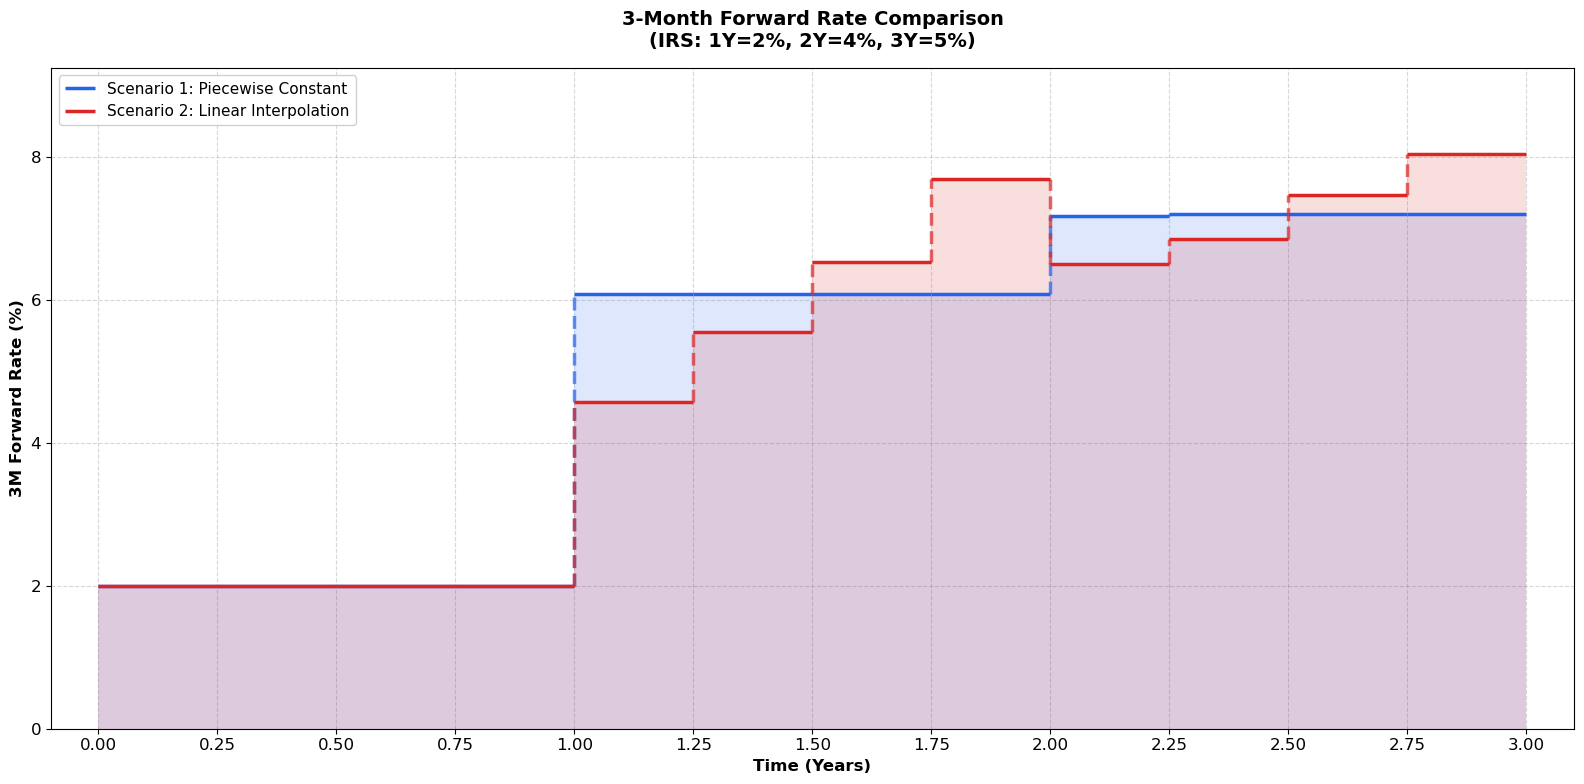

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': '3-Month Forward Rate Comparison\n(IRS: 1Y=2%, 2Y=4%, 3Y=5%)'}, xlabel='Time (Years)', ylabel='3M Forward Rate (%)'>)

In [9]:
# Step Function Plotter 생성
plotter = MultiStepFunctionPlotter(figsize=(16, 8))
plotter.add_scenario("Scenario 1: Piecewise Constant", intervals1)
plotter.add_scenario("Scenario 2: Linear Interpolation", intervals2)

# IRS 금리 문자열 생성
irs_str = ', '.join([f'{y}Y={r*100:.0f}%' for y, r in sorted(irs_rates.items())])

# 타임스탬프 포함 파일명 생성
fwd_filename = f"forward_rate_comparison_{get_timestamp()}.png"
print(f"저장 파일: {fwd_filename}")

# 차트 그리기
plotter.plot(
    title=f"3-Month Forward Rate Comparison\n(IRS: {irs_str})",
    xlabel="Time (Years)",
    ylabel="3M Forward Rate (%)",
    colors=['#2563eb', '#dc2626'],
    fill=True,
    fill_alpha=0.15,
    save_path=fwd_filename
)


## 10. Zero Rate 커브 시각화


저장 파일: zero_rate_comparison_20251218_103826.png


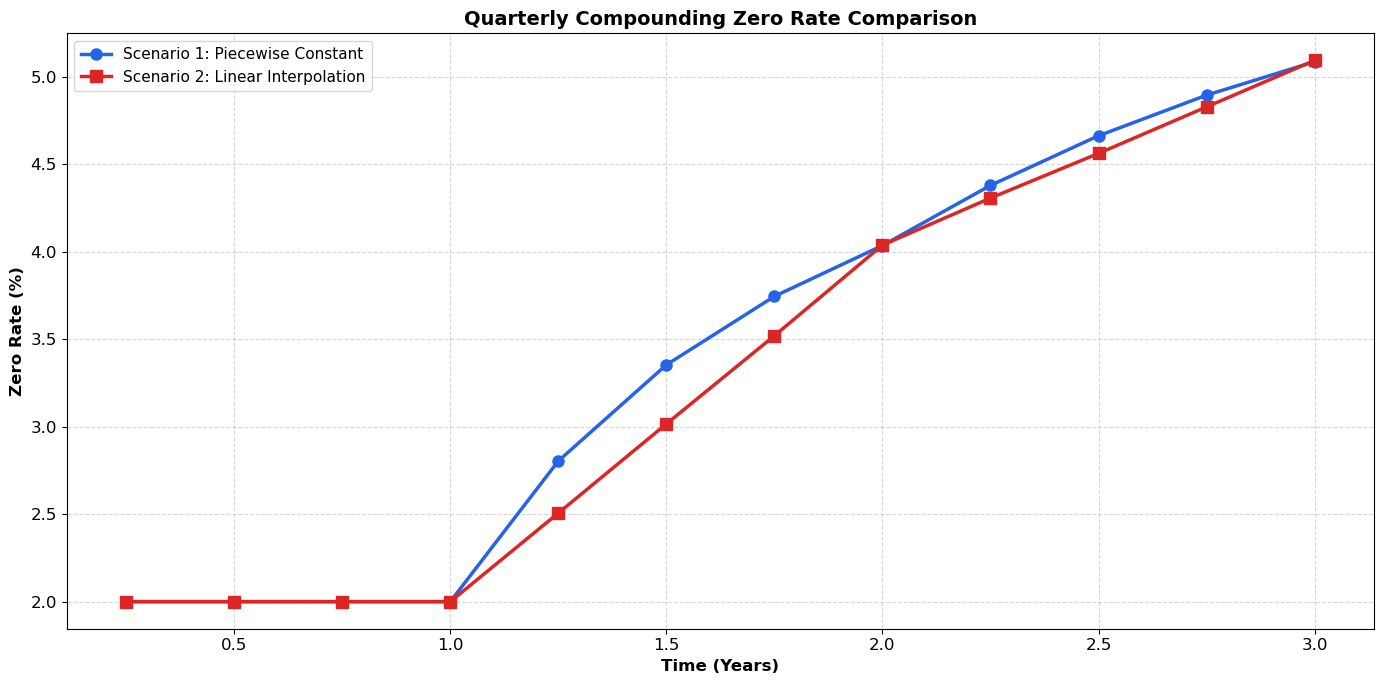

In [10]:
# 타임스탬프 포함 파일명 생성
zero_filename = f"zero_rate_comparison_{get_timestamp()}.png"
print(f"저장 파일: {zero_filename}")

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(comparison['Tenor (Years)'], comparison['Scenario 1 (%)'], 
        'o-', linewidth=2.5, markersize=8, color='#2563eb', label='Scenario 1: Piecewise Constant')
ax.plot(comparison['Tenor (Years)'], comparison['Scenario 2 (%)'], 
        's-', linewidth=2.5, markersize=8, color='#dc2626', label='Scenario 2: Linear Interpolation')

ax.set_xlabel('Time (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Zero Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Quarterly Compounding Zero Rate Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(zero_filename, dpi=150, bbox_inches='tight')
plt.show()


## 11. Discount Factor 비교


In [11]:
spot_date = curve1.referenceDate()
df_results = []

for tenor in maturities:
    target_date = spot_date + ql.Period(int(tenor * 12), ql.Months)
    df1_val = curve1.discount(target_date)
    df2_val = curve2.discount(target_date)
    
    df_results.append({
        'Tenor (Years)': tenor,
        'Scenario 1 DF': df1_val,
        'Scenario 2 DF': df2_val,
        'Difference': df1_val - df2_val
    })

df_comparison = pd.DataFrame(df_results)

print("Discount Factor 비교\n")
display(df_comparison.style.format({
    'Tenor (Years)': '{:.2f}',
    'Scenario 1 DF': '{:.8f}',
    'Scenario 2 DF': '{:.8f}',
    'Difference': '{:.8f}'
}))


Discount Factor 비교



,Tenor (Years),Scenario 1 DF,Scenario 2 DF,Difference
0,0.25,0.99509286,0.99509269,0.00000017
1,0.50,0.99010156,0.99010150,0.00000007
2,0.75,0.98513530,0.98513534,-0.00000004
3,1.00,0.98024752,0.98024753,-0.00000000
4,1.25,0.96576811,0.96933406,-0.00356595
5,1.50,0.95118796,0.95597215,-0.00478419
6,1.75,0.93682793,0.94049355,-0.00366562
7,2.00,0.92283727,0.92279884,0.00003842
8,2.25,0.90679495,0.90825667,-0.00146172
9,2.50,0.89062939,0.89284863,-0.00221924
